<a href="https://colab.research.google.com/github/guzonghua/saavlabs/blob/main/Lab2/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: PID Control
This lab will explore the use of PID control to control the movement of a `robot` or `vehicle` along a 2D racetrack. The track simply consist of a circular track with a radius of $50.0$ units. The robot is initially placed at the origin. To determine the track error, the robot's distance from the center of the track is calculated. For a perfect circle we can simply compare the position of the robot to the radius of the track:

\begin{equation*}

cte = \sqrt{(x - x_c)^2 + (y - y_c)^2} - r

\end{equation*}

where $x_c$ and $y_c$ are the coordinates of the center of the track and $r$ is the radius of the track. The track error is then used to calculate the steering angle of the robot using a PID controller. The steering angle is then used to update the robot's position and orientation. The robot's position and orientation is updated using two sets of equations. The first set of equations are used to update the robot's position and orientation when the robot is moving in a straight line. "Moving in a straight line" is defined as the robot's orientation being below a certain threshold. The second set of equations are used to update the robot's position and orientation when the robot is turning. "Turning" is defined as the robot's orientation being above a certain threshold. The robot's orientation is updated using the following equation:

### Straight Line

\begin{align*}
x_{t+1} &= x_t + v_t\cdot dt \cos(\theta_t) \\
y_{t+1} &= y_t + v_t\cdot dt \sin(\theta_t) \\
\theta_{t+1} &= \theta_t + \dot{\theta}_t\cdot dt
\end{align*}

### Circular motion

\begin{align*}
x_{t+1} &= x_c - R\sin(\theta_t) + R\sin(\theta_t + \dot{\theta}_t\cdot dt) \\
y_{t+1} &= y_c + R\cos(\theta_t) - R\cos(\theta_t + \dot{\theta}_t\cdot dt) \\
\theta_{t+1} &= \theta_t + \dot{\theta}_t\cdot dt \\
R &= \frac{v_t}{\dot{\theta}_t}
\end{align*}

where $x_t$, $y_t$, and $\theta_t$ are the robot's position and orientation at time $t$, $v_t$ is the robot's velocity at time $t$, $\dot{\theta}_t$ is the robot's angular velocity at time $t$, and $dt$ is the time step.

In [1]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------


 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    # def cte(self, radius): #Refer to L6 Control, p 28. # Previous track consisting of two semi-circles and a straight line (oval track)
    #     center1 = [radius, radius] 
    #     center2 = [radius, 3*radius]
    #     if self.x > radius and self.x < 3*radius: # If x lies in the center straight line segment
    #         if self.y > radius: #If y is above the center line, then compute vertical distance from (x,y) to the top edge of the track
    #             cte = self.y - (2*radius)
    #         else: #If y is below the center line, then compute vertical distance from the bottom edge of the track to (x,y)
    #             cte = -1.0 * self.y
    #     else:
    #         if self.x < 2*radius: #If x lies in the left semi-circle segment (self.x <= radius), then compute Euclidian distance from (x,y) to the perimeter of the left semi-circle 
    #             cte = ((self.x - center1[1])**2 + (self.y - center1[0])**2)**0.5 - radius
    #         else: #If x lies in the right semi-circle part (self.x >= 3*radius), then compute Euclidian distance from (x,y) to the perimeter of the right semi-circle
    #             cte = ((self.x - center2[1])**2 + (self.y - center2[0])**2)**0.5 - radius                
    #     return cte

    def cte(self, radius): # New circular track used in Lab 2.
        center = [radius, radius]
        cte = ((self.x - center[1])**2 + (self.y - center[0])**2)**0.5 - radius
        return cte
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, speed=1.0, N=1000, printflag = False, label = 'PID'):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    err = 0.0
    int_crosstrack_error = 0.0
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed) # motion distance is equal to speed (we assume time = 1)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        if printflag:
            print (myrobot)
    if printflag:
        # Plot the trajectory of the robot
        # plt.plot(x_trajectory, y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0, zorder=1)

        # # Plot the correct track (circle)
        # circle = plt.Circle((radius, radius), radius, color='b', fill=False, zorder=2)
        # plt.gca().add_artist(circle)

        # # Set the title and show the plot
        # plt.axis('equal')
        # plt.legend(['Trajectory', 'Track'], loc='lower left')
        # plt.title(label)
        # plt.show()

        # Plot the trajectory of the robot
        plt.plot(x_trajectory, y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0, zorder=1)

        # Plot the correct track (circle)
        circle = plt.Circle((radius, radius), radius, color='b', fill=False, zorder=2)
        plt.gca().add_artist(circle)

        # Determine the bounds for the plot
        track_min_x = radius - radius
        track_max_x = radius + radius
        track_min_y = radius - radius
        track_max_y = radius + radius

        # Include trajectory in the bounds
        min_x = min(track_min_x, min(x_trajectory))
        max_x = max(track_max_x, max(x_trajectory))
        min_y = min(track_min_y, min(y_trajectory))
        max_y = max(track_max_y, max(y_trajectory))

        offset = radius / 2.0
        min_x -= offset
        max_x += offset
        min_y -= offset
        max_y += offset

        # Set plot limits
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)

        # Set the title and equal aspect ratio
        plt.title(label)
        # Save figure as a PDF with DPI=300

        plt.gca().set_aspect('equal', adjustable='box')

        # Add a legend
        plt.legend(['Trajectory', 'Track'], loc='lower left')

        filename = label.split(':')[0] + '.pdf'
        plt.savefig("images/"+filename, dpi=300)
        # Show the plot
        plt.show()

    print('**********************************************************************************')
    print('\nFinal parameters: ', params)
    print('\nError: ', err)
    return err / float(N)

## Twiddle function

With the robot class and run function defined, we can now define the twiddle function. The twiddle function will be used to tune the PID controller to minimize the track error. The parameters of the PID controller are $K_p$, $K_i$, and $K_d$. The twiddle function will tune these parameters to minimize the track error. These parameters represent the proportional, integral, and derivative gains of the PID controller.

### Testing different controllers

We should now test different controller configurations. We will test:

* $K_p = 1.0$, $K_i = 1.0$, $K_d = 1.0$ - This is a PID controller which uses the proportional, integral, and derivative gains to control the robot.
* $K_p = 1.0$  $K_i = 0.0$, $K_d = 1.0$ - This is a PD controller which uses the proportional and derivative gains to control the robot.
* $K_p = 1.0$, $K_i = 1.0$, $K_d = 0.0$ - This is a PI controller which uses the proportional and integral gains to control the robot.
* $K_p = 1.0$, $K_i = 0.0$, $K_d = 0.0$ - This is a P controller which only uses the proportional gain to control the robot.

In [2]:

def twiddle(radius, speed, N, tol=0.2, p=None, dp=None): # Slightly modified to take different parameter values for the different controllers.
    if p is None:
        p = [0.9, 0.0, 0.0]
    if dp is None:
        dp = [1.0, 1.0, 1.0]  
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius, speed, N)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius, speed, N)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err


radius = 50.0 # Changed from 25.0 to 50
N = 1000
speed = 1.0
def format_params(params):  # Return string formatted parameters for LaTeX printing.
    return f'$K_p= {params[0]:.2f}$, $K_i= {params[2]:.2f}$, $K_d= {params[1]:.2f}$'

**********************************************************************************

Final parameters:  [0.9, 0.0, 0.0]

Error:  317122.8734889579
**********************************************************************************

Final parameters:  [1.9, 0.0, 0.0]

Error:  329648.88011315727
**********************************************************************************

Final parameters:  [-0.10000000000000009, 0.0, 0.0]

Error:  918695.6580140333
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 0.0]

Error:  176.0580306249187
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 1.0]

Error:  325242.6327576461
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, -1.0]

Error:  672222.1113947011
************************************************************

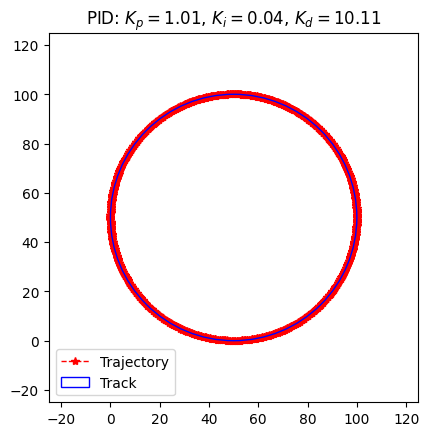

**********************************************************************************

Final parameters:  [1.0146845984670703, 10.111045387106246, 0.04425553655062349]

Error:  5.790870133046403e-26


In [3]:
# PID Controller
dp = [1.0, 1.0, 1.0]
p = [0.9, 0.0, 0.0]
params, err = twiddle(radius, speed, N, p=p, dp=dp)
err = run(params, radius, printflag=True, label=f'PID: {format_params(params)}')

**********************************************************************************

Final parameters:  [0.9, 0.0, 0.0]

Error:  317122.8734889579
**********************************************************************************

Final parameters:  [1.9, 0.0, 0.0]

Error:  329648.88011315727
**********************************************************************************

Final parameters:  [-0.10000000000000009, 0.0, 0.0]

Error:  918695.6580140333
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 0.0]

Error:  176.0580306249187
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 0.0]

Error:  176.0580306249187
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 0.0]

Error:  176.0580306249187
*************************************************************

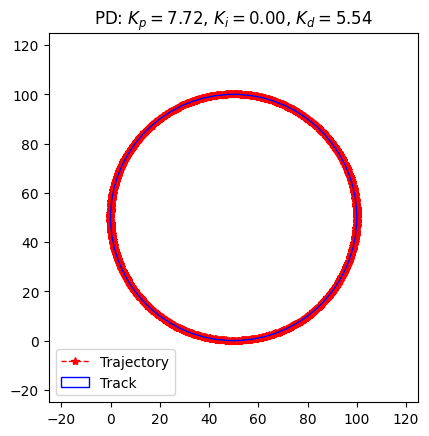

**********************************************************************************

Final parameters:  [7.715069121541531, 5.541200569117848, 0.0]

Error:  2.4281008015418504


In [4]:
# PD Controller
dp = [1.0, 1.0, 0.0]
p = [0.9, 0.0, 0.0]
params, err = twiddle(radius, speed, N, p=p, dp=dp)
err = run(params, radius, printflag=True, label=f'PD: {format_params(params)}')

**********************************************************************************

Final parameters:  [0.9, 0.0, 0.0]

Error:  317122.8734889579
**********************************************************************************

Final parameters:  [1.9, 0.0, 0.0]

Error:  329648.88011315727
**********************************************************************************

Final parameters:  [-0.10000000000000009, 0.0, 0.0]

Error:  918695.6580140333
**********************************************************************************

Final parameters:  [0.8999999999999999, 0.0, 0.0]

Error:  317122.88545104803
**********************************************************************************

Final parameters:  [0.8999999999999999, 0.0, 0.0]

Error:  317122.88545104803
**********************************************************************************

Final parameters:  [0.8999999999999999, 0.0, 1.0]

Error:  604649.1713495865
***********************************************************

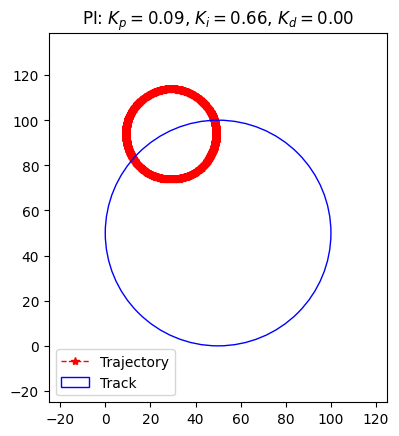

**********************************************************************************

Final parameters:  [0.08999999999999987, 0.0, 0.6561]

Error:  193772.8984976059


In [5]:
# PI Controller
dp = [1.0, 0.0, 1.0]
p = [0.9, 0.0, 0.0]
params, err = twiddle(radius, speed, N, p=p, dp=dp)
err = run(params, radius, printflag=True, label=f'PI: {format_params(params)}')

**********************************************************************************

Final parameters:  [0.9, 0.0, 0.0]

Error:  317122.8734889579
**********************************************************************************

Final parameters:  [1.9, 0.0, 0.0]

Error:  329648.88011315727
**********************************************************************************

Final parameters:  [-0.10000000000000009, 0.0, 0.0]

Error:  918695.6580140333
**********************************************************************************

Final parameters:  [0.8999999999999999, 0.0, 0.0]

Error:  317122.88545104803
**********************************************************************************

Final parameters:  [0.8999999999999999, 0.0, 0.0]

Error:  317122.88545104803
**********************************************************************************

Final parameters:  [0.8999999999999999, 0.0, 0.0]

Error:  317122.88545104803
**********************************************************

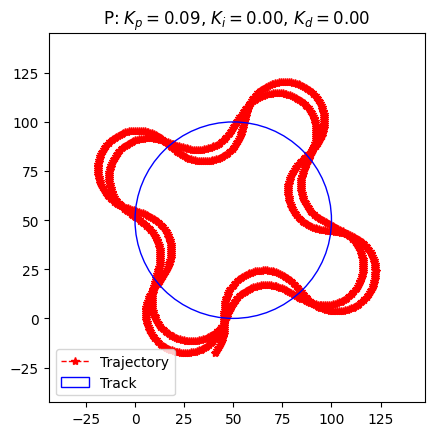

**********************************************************************************

Final parameters:  [0.08999999999999989, 0.0, 0.0]

Error:  217934.60353583324


In [6]:
# P Controller
dp = [1.0, 0.0, 0.0]
p = [0.9, 0.0, 0.0]
params, err = twiddle(radius, speed, N, p=p, dp=dp)
err = run(params, radius, printflag=True, label=f'P: {format_params(params)}')

<!-- Visualize the plots in a grid, they are stored in 'images/*.pdf'-->

<table>
  <tr>
    <td><embed src="./images/PID.pdf" type="application/pdf" /></td>
    <td><embed src="./images/PD.pdf" type="application/pdf" /></td>
  </tr>
  <tr>
    <td><embed src="./images/PI.pdf" type="application/pdf" /></td>
    <td><embed src="./images/P.pdf" type="application/pdf" /></td>
  </tr>
</table>

